In [1]:
import numpy as np
from numpy.random import default_rng
from numpy.fft import fft, ifft, fftfreq
import matplotlib.pyplot as plt

In [2]:
N = 2048
x = (2*np.pi*np.arange(1,N+1)/N)
rng = default_rng(0)
u = rng.standard_normal(N).astype('float128')
v = fft(u)
nu = 0.05

# spatial grid and initial conditions
h = 0.01
k = (np.r_[np.arange(0, N/2), np.array([0]), np.arange(-N/2+1, 0)]/16).astype('float128')
L = k**2 - nu*k**4
exp1 = np.exp(h*L)
exp2 = np.exp(h*L/2)
M = 16
r = np.exp(1j*np.pi*(np.arange(1, M+1)-0.5) / M)
LR = h*np.repeat([L], M, axis=0).T + np.repeat([r], N, axis=0)
Q = h*np.real(np.mean((np.exp(LR/2)-1)/LR, axis=1))
f1 = h*np.real(np.mean((-4-LR+np.exp(LR)*(4-3*LR+LR**2))/LR**3, axis=1))
f2 = h*np.real(np.mean((2+LR+np.exp(LR)*(-2+LR))/LR**3, axis=1))
f3 = h*np.real(np.mean((-4-3*LR-LR**2+np.exp(LR)*(4-LR))/LR**3, axis=1))

tmax = 10
step_max = round(tmax/h)
step_plt = int(tmax/(1000*h))
dt = h
g = -0.5j*k
# tt = np.zeros(step_max)
# uu = np.zeros((N,step_max))
uu = np.array([u])
tt = 0

for step in range(1, step_max):
    t = step*h
    Nv = g*fft(np.real(ifft(v))**2)
    a = exp2*v + Q*Nv
    Na = g*fft(np.real(ifft(a))**2)
    b = exp2*v + Q*Na
    Nb = g*fft(np.real(ifft(b))**2)
    c = exp2*a + Q*(2*Nb - Nv)
    Nc = g*fft(np.real(ifft(c))**2)
    v = exp1*v + Nv*f1 + 2*(Na+Nb)*f2 + Nc*f3
    if step % step_plt == 0:
        u = np.real(ifft(v))
        uu = np.append(uu, np.array([u]), axis=0)
        tt = np.hstack((tt, t))
        # uu[:,step] = u
        # tt[step] = t

/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.


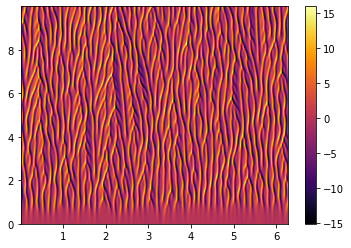

x shape: (2048,)
tt shape: (1000,)
uu shape: (1000, 2048)
(1000, 2048) (1000, 2048) <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.matrix'>


In [3]:
fig, ax = plt.subplots(1,1)
X, T = np.meshgrid(x, tt)
uu = np.matrix(uu)
im = ax.pcolormesh(X, T, uu, cmap='inferno', rasterized=True)
fig.colorbar(im)
plt.show()
print('x shape:', x.shape)
print('tt shape:', tt.shape)
print('uu shape:', uu.shape)
print(X.shape, T.shape, type(X), type(T), type(uu))

In [4]:
#u.shape = (uu.shape[0], 1)
#print(X.shape, T.shape, u.shape)

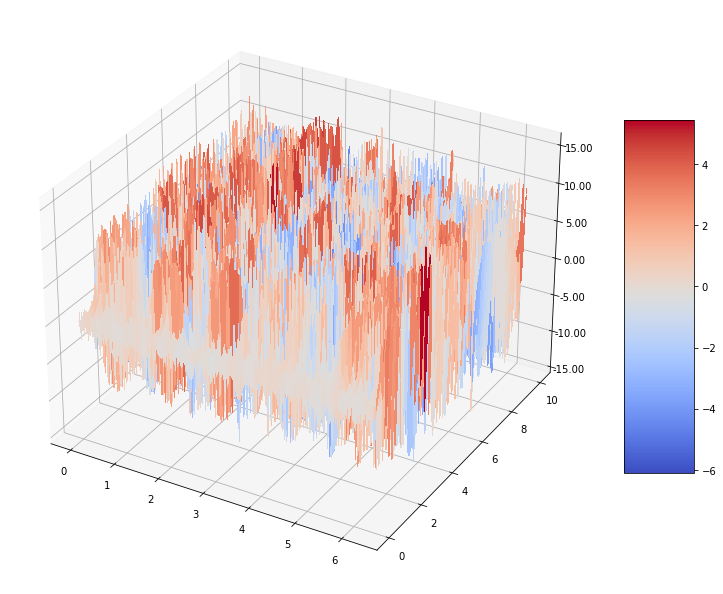

In [5]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(13,13))
#fig = plt.figure(figsize=(31,31))

# Plot the surface.
surf = ax.plot_surface(X, T, uu, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_ylim(10, 10.2)
#ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [6]:
import numpy as np
# get two views of the data matrix offset by one time step
uu = uu.T
print(type(uu))
uu = np.matrix(uu,dtype='complex128')
print(type(uu[1,1]))
print('uu shape:', uu.shape)
X1 = np.matrix(uu[:, 0:-2]) #augmented input data state space
X2 = np.matrix(uu[:, 1:-1]) #augmented output data state space
print('X1 shape:',X1.shape)
print('X2 shape:',X2.shape)
# Run SVD on the data view of X1
U,s,Vh = np.linalg.svd(X1)
V = Vh.conj().T
S = np.matrix(np.diag(s))


<class 'numpy.matrix'>
<class 'numpy.complex128'>
uu shape: (2048, 1000)
X1 shape: (2048, 998)
X2 shape: (2048, 998)


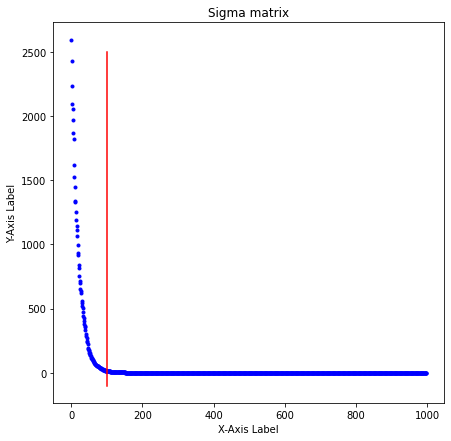

In [7]:
fig = plt.figure(figsize=(7,7))

# Creating subplot/axes
ax = fig.add_subplot(111)

# Setting axes/plot title
ax.set_title('Sigma matrix')

# Setting X-axis and Y-axis limits
#ax.set_xlim([0.5, 4.5])
#ax.set_ylim([-3, 7])
r = 100 #rank truncation
ax.plot(s,'.', color='blue')
ax.plot([r, r], [-100, 2500], color='red')

# Setting X-axis and Y-axis labels
ax.set_ylabel('Y-Axis Label')
ax.set_xlabel('X-Axis Label')

# Showing the plot
plt.show()


In [8]:
Ur = U[:, 0:r]
Sr = S[0:r, 0:r]
Vr = V[:, 0:r]

# Approach 1: works because Sr is square
#Atilde = Ur.conj().T*X2*Vr*np.linalg.inv(Sr)
#print(Atilde)

# Approach 2: more general, use least squares to solve aT xT = bT, where:
#   xT = Atilde
#   aT = Sr
#   bT = Ur.conj().T*X2*Vr
__b = Ur.conj().T*X2*Vr
__a = Sr
__r = np.linalg.lstsq(__a.T, __b.T)
__x = __r[0].T
Atilde = __x
#print('Atilde:',Atilde)

lamb, W = np.linalg.eig(Atilde)
omega = np.log(lamb)/dt
print('omega:',omega)

# Solve for Phi. Again, the inverse method works because Sr is square.
Phi = X2*Vr*np.linalg.inv(Sr)*W #Compute DMD modes
print(Phi.shape)

x1 = np.matrix(uu[:,0])
print(Phi.shape,x1.shape)
b, resid, rank, s = np.linalg.lstsq(Phi, x1)
print('b:',b)

time_dynamics = None
for i in range(X1.shape[1]):
    v = np.array(b)[:,0]*np.exp( np.array(omega)*(i+1)*dt)
    if time_dynamics is None:
        time_dynamics = v
    else:
        time_dynamics = np.vstack((time_dynamics, v))
print(time_dynamics.shape)
print(Phi.shape)
X_dmd = np.dot( np.array(Phi), time_dynamics.T)
print('X_dmd shape:',X_dmd.shape)

omega: [-3.71046335e+02+1.77257256e-14j -4.00788469e-01+3.33755866e+01j
 -4.00788469e-01-3.33755866e+01j -8.04841100e-01+3.18512473e+01j
 -8.04841100e-01-3.18512473e+01j -3.22609567e-01+3.07934622e+01j
 -3.22609567e-01-3.07934622e+01j -1.88680437e-01+2.89453162e+01j
 -1.88680437e-01-2.89453162e+01j -4.66899350e-01-2.85168828e+01j
 -4.66899350e-01+2.85168828e+01j -2.00145239e-01-2.78896917e+01j
 -2.00145239e-01+2.78896917e+01j -3.64367896e-01+2.71978817e+01j
 -1.75653075e-01+2.66487389e+01j -3.64367896e-01-2.71978817e+01j
 -1.75653075e-01-2.66487389e+01j -1.89039401e-01+2.57193544e+01j
 -1.89039401e-01-2.57193544e+01j  4.03941284e-02+2.52301824e+01j
  4.03941284e-02-2.52301824e+01j -1.33063779e-02+2.45291162e+01j
 -1.33063779e-02-2.45291162e+01j  1.21140148e-01+2.37425161e+01j
  2.99064940e-01+2.32650240e+01j  1.21140148e-01-2.37425161e+01j
  2.99064940e-01-2.32650240e+01j  1.38015444e-01+2.26669891e+01j
  1.38015444e-01-2.26669891e+01j  1.11136539e-01+2.17071136e+01j
  1.11136539e-01-2

/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  from ipykernel import kernelapp as app
/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


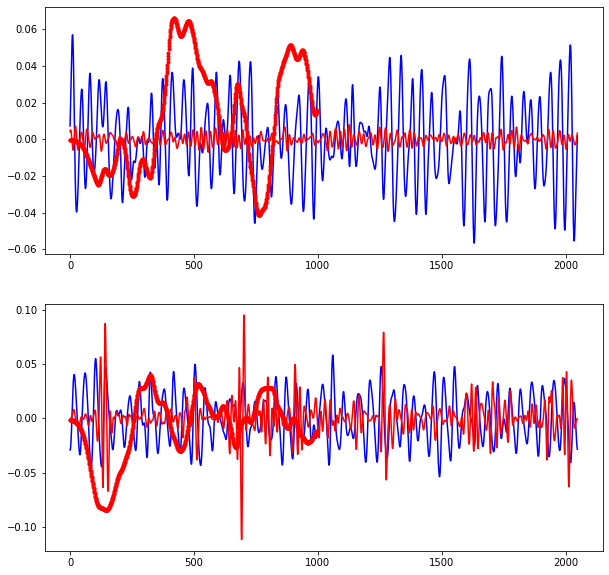

In [9]:
fig = plt.figure(figsize=(10,10))
N = 2
for i in range(N):
    ax = fig.add_subplot(N,1,1+i)
    ax.plot(np.real(Ur[:,i]), color='blue')
    ax.plot(np.real(Vr[:,i]), '.', color='red')
    ax.plot(np.real(Phi[:,i]), color='red')

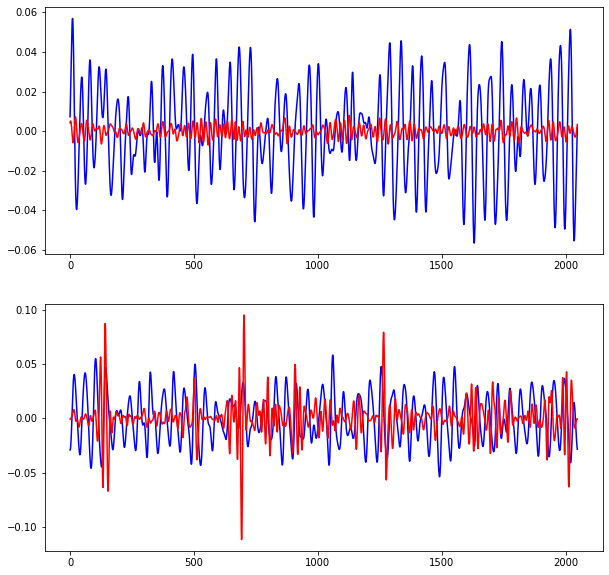

In [10]:
fig = plt.figure(figsize=(10,10))
N = 2
for i in range(N):
    ax = fig.add_subplot(N,1,1+i)
    ax.plot(np.real(Ur[:,i]), color='blue')
    ax.plot(np.real(Phi[:,i]), color='red')

(2048, 1000) (2048, 998) (998,)
X shape: (1000, 2048)
(1, 1000) (998,)
(1, 1000) (998,)
(1, 1000) (998,)


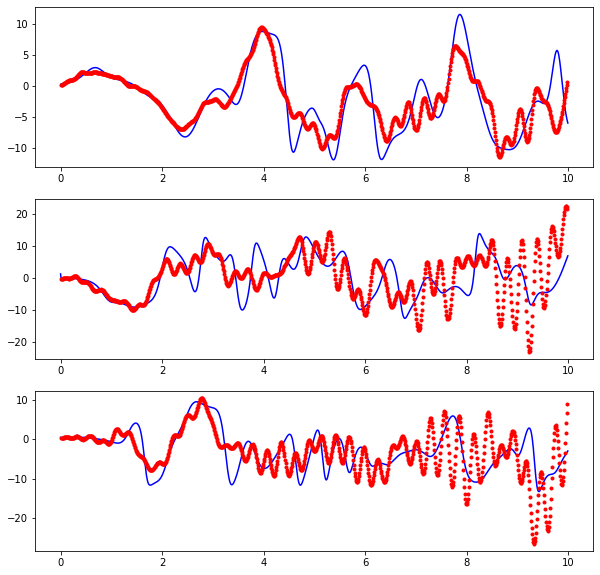

In [11]:
print(uu.shape,X_dmd.shape,tt[1:-1].shape)
fig = plt.figure(figsize=(10,10))
N = 3
print('X shape:',X.shape)
for i in range(N):
    ax = fig.add_subplot(N,1,1+i)
    row = int(X.shape[0]/float(N+1))*(i+1)
    print(np.array(uu[row,:]).shape,X_dmd[row,:].shape)
    ax.plot(tt, np.real(uu[row,:]).T, color='blue')
    ax.plot(tt[1:-1], np.real(X_dmd[row,:]), '.', color='red')

(2048, 1000) (2048, 998) (998,)
X shape: (1000, 2048)
250
(1, 1000) (998,)
500
(1, 1000) (998,)
750
(1, 1000) (998,)


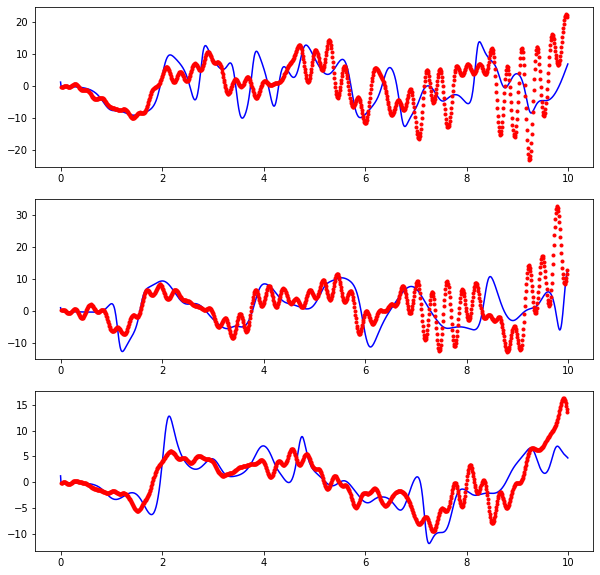

In [12]:
print(uu.shape,X_dmd.shape,tt[1:-1].shape)
fig = plt.figure(figsize=(10,10))
N = 3
print('X shape:',X.shape)
for i in range(N):
    ax = fig.add_subplot(N,1,1+i)
    row = int(X.shape[0]/float(N+1))*(i+1)
    print(row)
    print(np.array(uu[row,:]).shape,X_dmd[row,:].shape)
    ax.plot(tt, np.real(uu[2*row,:]).T, color='blue')
    ax.plot(tt[1:-1], np.real(X_dmd[2*row,:]), '.', color='red')

In [13]:
import pandas as pd

nn_input = np.real(X1.T)
nn_output = np.real(X2.T)
#X_lorenz_data = np.asarray([ x, y, z ]).T
print(nn_input.shape)
print(nn_output.shape)
#row = np.array(['x', 'y', 'z']).T
#row_n = row.shape[0] ##last row
#X_lorenz_data1 = np.append(row,[X_lorenz_data1],axis=0)
#X_lorenz_data1 = np.insert(X_lorenz_data1,row_n,[row],axis=0)
#print(nn_input, nn_output)
# Create the pandas DataFrame
Xks_input_dataframe = pd.DataFrame(nn_input)
#X_lorenz_input_dataframe.set_index('index', drop=True, inplace=True)
Xks_input_dataframe.index.names = ['index']
Xks_input_dataframe.to_csv('ks_input_data.csv')
#X_lorenz_output_dataframe = pd.DataFrame(nn_output, columns=['x', 'y', 'z'])
Xks_output_dataframe = pd.DataFrame(nn_output)
Xks_output_dataframe.index.names = ['index']
Xks_output_dataframe.to_csv('ks_output_data.csv')
#x0 = initial conditions
x0ks_input_dataframe = pd.DataFrame(x1)
#X_lorenz_input_dataframe.set_index('index', drop=True, inplace=True)
x0ks_input_dataframe.index.names = ['index']
x0ks_input_dataframe.to_csv('ks_input_init_data.csv')
#np.savetxt("lorenz_data.csv", X_lorenz_dataframe, delimiter=",")
#lorenz_data = pd.read_csv("lorenz_data.csv", header=None)
#lorenz_data.to_csv("lorenz_data.csv", header=["x", "y", "z"], index=False)
 
# print dataframes.
Xks_input_dataframe
Xks_output_dataframe
x0ks_input_dataframe
print('Xks_input_dataframe shape:',Xks_input_dataframe.shape)
print('Xks_output_dataframe shape:',Xks_output_dataframe.shape)
print('x0ks_input_dataframe shape:',x0ks_input_dataframe.shape)

(998, 2048)
(998, 2048)
Xks_input_dataframe shape: (998, 2048)
Xks_output_dataframe shape: (998, 2048)
x0ks_input_dataframe shape: (2048, 1)
